In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import tensorflow
import os, sys
import matplotlib.image as mpimg
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from skimage.color import rgb2gray

# Prepare blurred and noised image

x(u,v) = original image

h(u,v) = channel (in this case will be a slight blur to the image, according to https://datacarpentry.org/image-processing/06-blurring/). A motion blur is applied since it is a linear filtering

n(u,v) = gaussian noise

y(u,v) = H(n,m)X(n,m) + N(n,m)

In [106]:
def prepare_image(x, kernel_size, noise_var, noise_factor):

## Com blur
    # Motion blur image
    h = np.zeros((kernel_size, kernel_size))

    # Fill the middle row with ones
    h[int((kernel_size - 1)/2), :] = np.ones(kernel_size)

    # Normalize
    h /= kernel_size

    # 2D convolution h*x
    hx = cv.filter2D(x, -1, h)

    # Add noise
    row,col = hx.shape
    mean = 0
    sigma = noise_var**0.5
    n = noise_factor * np.random.normal(mean,sigma,(row,col))
    n = n.reshape(row,col)
    y = hx + n
    y = np.clip(y, 0., 1.)

    return h, y, n

# Wiener Filter

#### Calculate equalization filter coefficients W

In [4]:
def calculate_w_coef(x, h, y, n):
    
    # Fourier transform
    X = np.fft.fft2(x)
    Y = np.fft.fft2(y)
    N = np.fft.fft2(n)
    H = np.fft.fft2(h)

    # Prepare variables
    Sxx = np.mean(np.power(abs(X),2))
    Snn = np.mean(np.power(abs(N),2))
    H_conj = np.conj(H)
    H_abs = np.power(np.abs(H),2)

    # Calculate W coefficients
    W = (Sxx*H_conj)/(Sxx*H_abs + Snn)

    # Calculate estimated value
    w = np.abs(np.fft.ifft2(W))
    estimated_x = cv.filter2D(y, -1, w) 
    
    return X, Y, N, H, estimated_x

#### Calculate coefficients W with manual parameter K

In [5]:
def calculate_W_coef_K(x, y, n, h, K):

    # Fourier transform
    X = np.fft.fft2(x)
    Y = np.fft.fft2(y)
    N = np.fft.fft2(n)
    H = np.fft.fft2(h, s = x.shape)

    # Prepare variables
    W = np.conj(H) / (np.abs(H) ** 2 + K)
    estimated_X = W * Y
    estimated_x = np.abs(np.fft.ifft2(estimated_X))

    return X, Y, N, H, estimated_x

#### Plot function

In [21]:
# wiener_type = 0 for without K and 1 for with K
def test_wiener_filter(x, wiener_type, K, kernel_size, noise_var, noise_factor, figsize):

    (h, y, n) = prepare_image(x, kernel_size, noise_var, noise_factor)

    if wiener_type == 0:
        (X, Y, N, H, estimated_x) = calculate_w_coef(x, h, y, n)
    else:
        (X, Y, N, H, estimated_x) = calculate_W_coef_K(x, y, n, h, K=0.08)


    f = np.fft.fft2(X)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))

    # Calculo erros
    erro_blur_e_noise = np.mean(np.power(y-x,2))
    erro_filtered = np.mean(np.power(estimated_x-x,2))

    plt.figure(figsize=figsize)
    plt.imshow(x, cmap = 'gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])

    print('Erro quadrático médio imagem com blur e ruído = ' + str(erro_blur_e_noise))
    plt.figure(figsize=figsize)
    plt.imshow(y, cmap = 'gray')
    plt.title('Blurred image + noise'), plt.xticks([]), plt.yticks([])

    print('Erro quadrático médio imagem filtrada = ' + str(erro_filtered))
    plt.figure(figsize=figsize)
    plt.imshow(estimated_x, cmap = 'gray')
    plt.title('Filtered image'), plt.xticks([]), plt.yticks([])

    plt.show()
    
    return estimated_x, y

#### Plot frequency spectrum function

In [29]:
def plot_freq(x, estimated_x, y, figsize):
    
    X = np.fft.fft2(x)
    X_shift = np.fft.fftshift(X)
    X_spectrum = 20*np.log(np.abs(X_shift))   

    Y = np.fft.fft2(y)
    Y_shift = np.fft.fftshift(Y)
    Y_spectrum = 20*np.log(np.abs(Y_shift))

    estimated_X = np.fft.fft2(estimated_x)
    estimated_X_shift = np.fft.fftshift(estimated_X)
    estimated_X_spectrum = 20*np.log(np.abs(estimated_X_shift))
    
    plt.figure(figsize=figsize)
    plt.imshow(X_spectrum, cmap='gray')
    plt.title("Input image")

    plt.figure(figsize=figsize)
    plt.imshow(Y_spectrum, cmap='gray')
    plt.title("Blurred image + noise")
    
    plt.figure(figsize=figsize)
    plt.imshow(estimated_X_spectrum, cmap='gray')
    plt.title("Filter output")
    

### High resolution image with classic Wiener 

Erro quadrático médio imagem com blur e ruído = 1291.6908691771682
Erro quadrático médio imagem filtrada = 494.9565187731014


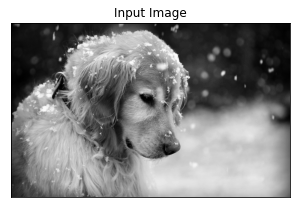

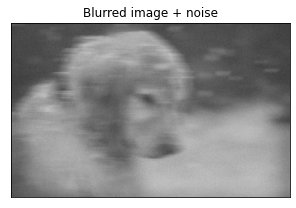

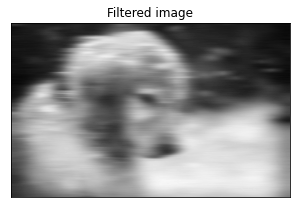

In [35]:
# Load image
x = cv.imread('./Images/dog.jpeg',0)
(estimated_x, y) = test_wiener_filter(x, wiener_type=0, K=0, kernel_size=100, noise_var=900, noise_factor=1, figsize=(5,5))


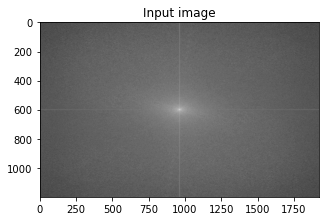

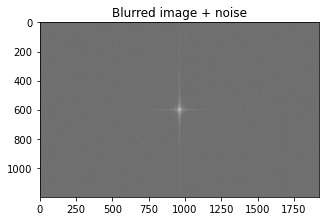

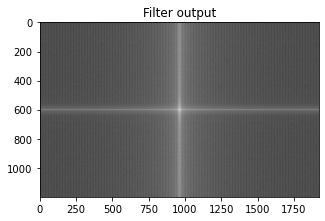

In [36]:
# Frequency domain
plot_freq(x, estimated_x, y, (5,5))

### High resolution image with K parameter Wiener

Erro quadrático médio imagem com blur e ruído = 1292.551865135286
Erro quadrático médio imagem filtrada = 2634.43849587451


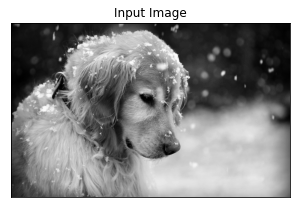

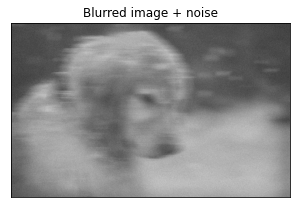

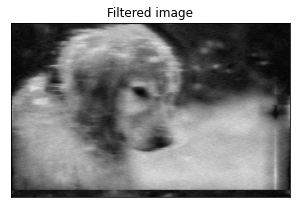

In [31]:
# Load image
x = cv.imread('./Images/dog.jpeg',0)

(estimated_x, y) = test_wiener_filter(x, wiener_type=1, K=0.08, kernel_size=100, noise_var=900, noise_factor=1, figsize=(5,5))

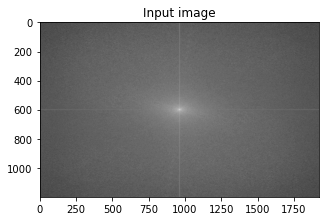

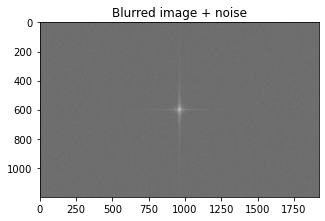

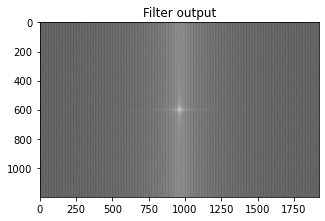

In [32]:
# Frequency domain
plot_freq(x, estimated_x, y, (5,5))

### Wiener Filter with image from MNIST dataset

Erro quadrático médio imagem com blur e ruído = 0.061412173605457865
Erro quadrático médio imagem filtrada = 0.04018187445800712


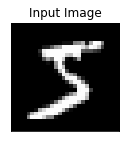

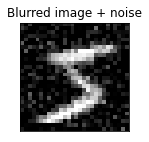

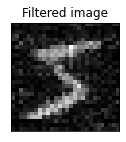

(array([[8.14282413e-02, 1.52590225e-01, 1.58297493e-02, 1.14967082e-01,
         4.26131398e-02, 8.08344047e-02, 1.25554362e-01, 3.32552980e-02,
         6.91978495e-02, 8.08271413e-02, 4.27748989e-02, 3.26681632e-02,
         1.26903532e-01, 1.43802592e-01, 1.10469193e-01, 2.39720558e-01,
         3.17043972e-01, 1.94913547e-01, 2.07735549e-02, 3.52383394e-01,
         3.01086738e-01, 1.83673805e-01, 2.05309019e-01, 9.37827546e-02,
         7.51085682e-02, 4.14161088e-02, 2.28645469e-01, 2.76774266e-01],
        [1.92246775e-02, 6.07227121e-02, 2.51534805e-02, 6.08435414e-02,
         4.32478016e-02, 1.13338684e-01, 8.98110866e-02, 1.10508818e-01,
         1.39893162e-01, 1.84573331e-01, 1.00957223e-01, 1.54373671e-01,
         2.04645232e-02, 1.29218915e-02, 7.12284216e-02, 7.00485925e-02,
         1.48058418e-01, 2.84579459e-01, 1.16074549e-01, 2.89988686e-02,
         6.57145251e-02, 3.50760781e-03, 6.15334379e-02, 3.54320651e-02,
         8.06200982e-02, 8.97067758e-02, 2.5043445

In [124]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

noise_factor = 0.2
x_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x = X_train[0]

test_wiener_filter(x, wiener_type=1, K=0.007, kernel_size=4, noise_var=1, noise_factor=0.15, figsize=(2,2))

# Multilayer Perceptron (MLP)

#### Imports and load

In [37]:
# Load train and test images
#X_train = []
#X_test = []
#my_train_path = './Dataset/train_images/'
#my_test_path = './Dataset/test_images/'
#for img in os.listdir(my_train_path):
#    imported_image = cv.imread(my_train_path + img, 0)
#    if imported_image.shape[0] > imported_image.shape[1]:  # Invert vertical images to horizontal
#        imported_image = cv.rotate(imported_image, cv.cv2.ROTATE_90_CLOCKWISE)
#    X_train.append(imported_image)
    
#for img in os.listdir(my_test_path):
#    imported_image = cv.imread(my_test_path + img, 0)
#    if imported_image.shape[0] > imported_image.shape[1]:  # Invert vertical images to horizontal
#        imported_image = cv.rotate(imported_image, cv.cv2.ROTATE_90_CLOCKWISE)
#    X_test.append(imported_image)

# Change list to array
#imported_train = np.array(X_train, dtype=int)
#imported_test = np.array(X_test, dtype=int)

(imported_X_train, imported_Y_train), (imported_X_test, imported_Y_test) = mnist.load_data()


#### Prepare images

In [38]:
X_train = imported_X_train
X_test = imported_X_test

# Convert into greyscale
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# Reshape to 28 x 28 pixels = 784 features
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels)
X_test = X_test.reshape(X_test.shape[0], num_pixels)

# Add noise
noise_factor = 0.2
x_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
x_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

#print(x_train_noisy.shape)
# Plot for proofs
#plt.figure(figsize=(2,2))
#plt.imshow(X_train[57], cmap='gray')
#plt.show()

#plt.figure(figsize=(2,2))
#plt.imshow(x_train_noisy[57], cmap='gray')
#plt.show()

#### Model and prediction



In [229]:
# Create the model
model = Sequential()
model.add(Dense(500, input_dim=num_pixels, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(num_pixels, activation='sigmoid'))

# Configure the model and start training
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train_noisy, X_train, validation_data=(x_test_noisy, X_test), epochs=5, batch_size=200)

# Final evaluation of the model
pred = model.predict(x_test_noisy)

Epoch 1/5
300/300 [==============================] - 7s 21ms/step - loss: 0.0411 - val_loss: 0.0197
Epoch 2/5
300/300 [==============================] - 6s 20ms/step - loss: 0.0167 - val_loss: 0.0142
Epoch 3/5
300/300 [==============================] - 6s 20ms/step - loss: 0.0130 - val_loss: 0.0119
Epoch 4/5
300/300 [==============================] - 6s 20ms/step - loss: 0.0111 - val_loss: 0.0102
Epoch 5/5
300/300 [==============================] - 6s 20ms/step - loss: 0.0100 - val_loss: 0.0093


#### Plot for proofs

Test Image


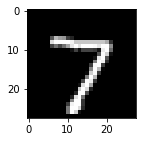

Test Image with Noise


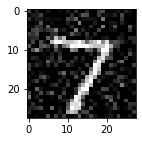

Reconstruction of Noisy Test Images


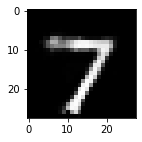

In [230]:
X_test = np.reshape(X_test, (10000,28,28)) *255
pred = np.reshape(pred, (10000,28,28)) *255
x_test_noisy = np.reshape(x_test_noisy, (-1,28,28)) *255

img_number = 0

plt.figure(figsize=(10, 2))
print("Test Image")
plt.imshow(X_test[img_number,:,:], cmap='gray')
plt.show() 

plt.figure(figsize=(10, 2))
print("Test Image with Noise")
plt.imshow(x_test_noisy[img_number,:,:], cmap='gray')
plt.show()    

plt.figure(figsize=(10, 2))
print("Reconstruction of Noisy Test Images")
plt.imshow(pred[img_number,:,:], cmap='gray')  
plt.show()

## MLP with 1 layer for comparison with Wiener filter

In [71]:
def run_MLP_1layer(X_train, X_test, epochs, batch_size, model_type, test_image_number):

    # Convert into greyscale
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255

    # Reshape to 28 x 28 pixels = 784 features
    num_pixels = X_train.shape[1] * X_train.shape[2]
    X_train = X_train.reshape(X_train.shape[0], num_pixels)
    X_test = X_test.reshape(X_test.shape[0], num_pixels)

    # Add noise
    noise_factor = 0.2
    x_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
    x_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)

    # Create the model
    model = Sequential()
    if model_type == 2:
        model.add(Dense(300, input_dim=784, activation='sigmoid'))
        model.add(Dense(500, activation='sigmoid'))
        model.add(Dense(784, activation='sigmoid'))
    else:
        model.add(Dense(500, input_dim=784, activation='relu'))
        model.add(Dense(784, activation='sigmoid'))
        

    # Configure the model and start training
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train_noisy, X_train, validation_data=(x_test_noisy, X_test), epochs=epochs, batch_size=batch_size)

    # Final evaluation of the model
    pred = model.predict(x_test_noisy)
    
    X_test = np.reshape(X_test, (2,28,28)) *255
    pred = np.reshape(pred, (2,28,28)) *255
    x_test_noisy = np.reshape(x_test_noisy, (-1,28,28)) *255

    img_number = test_image_number

    plt.figure(figsize=(10, 2))
    print("Test Image")
    plt.imshow(X_test[img_number,:,:], cmap='gray')
    plt.show() 

    plt.figure(figsize=(10, 2))
    print("Test Image with Noise")
    plt.imshow(x_test_noisy[img_number,:,:], cmap='gray')
    plt.show()    

    plt.figure(figsize=(10, 2))
    print("Reconstruction of Noisy Test Images")
    plt.imshow(pred[img_number,:,:], cmap='gray')  
    plt.show()
    
    return pred

#### MNIST dataset

Epoch 1/20
1/1 [==============================] - 0s 196ms/step - loss: 0.2307 - val_loss: 0.2122
Epoch 2/20
1/1 [==============================] - 0s 23ms/step - loss: 0.2055 - val_loss: 0.1939
Epoch 3/20
1/1 [==============================] - 0s 27ms/step - loss: 0.1806 - val_loss: 0.1732
Epoch 4/20
1/1 [==============================] - 0s 24ms/step - loss: 0.1523 - val_loss: 0.1501
Epoch 5/20
1/1 [==============================] - 0s 26ms/step - loss: 0.1213 - val_loss: 0.1263
Epoch 6/20
1/1 [==============================] - 0s 22ms/step - loss: 0.0902 - val_loss: 0.1040
Epoch 7/20
1/1 [==============================] - 0s 25ms/step - loss: 0.0621 - val_loss: 0.0853
Epoch 8/20
1/1 [==============================] - 0s 25ms/step - loss: 0.0395 - val_loss: 0.0714
Epoch 9/20
1/1 [==============================] - 0s 23ms/step - loss: 0.0234 - val_loss: 0.0624
Epoch 10/20
1/1 [==============================] - 0s 25ms/step - loss: 0.0131 - val_loss: 0.0575
Epoch 11/20
1/1 [===========

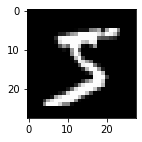

Test Image with Noise


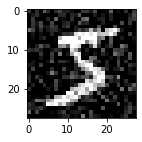

Reconstruction of Noisy Test Images


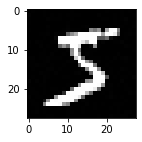

In [66]:
(imported_X_train, imported_Y_train), (imported_X_test, imported_Y_test) = mnist.load_data()

X_train = imported_X_train
X_test = imported_X_test
X_test = X_train[0:2] # Train and test here are the same images
X_train = X_train[0:1]

pred = run_MLP_1layer(X_train, X_test, epochs=20, batch_size=1, model_type=1, test_image_number=0)

Results

In this case it was tried to use MLP as approximately a Wiener filter. It was used 1 layer with the number of neurons equal the number of pixels, since we needed all pixels as output to recover the entire image. Running with 50 epochs is enough to achieve a good result, i.e. find the right values for the weights while calculating the MSE between the outputs and the original image. 
The activation function also plays an important role, since the "sigmoid" achieved a better result compared to "relu". 



#### Trying to predict with another image

Using the same model, we tried to predict for other image rather than "5". 

Epoch 1/50
1/1 [==============================] - 0s 172ms/step - loss: 0.2385 - val_loss: 0.2141
Epoch 2/50
1/1 [==============================] - 0s 23ms/step - loss: 0.2056 - val_loss: 0.1926
Epoch 3/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1753 - val_loss: 0.1730
Epoch 4/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1480 - val_loss: 0.1552
Epoch 5/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1238 - val_loss: 0.1395
Epoch 6/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1028 - val_loss: 0.1256
Epoch 7/50
1/1 [==============================] - 0s 21ms/step - loss: 0.0848 - val_loss: 0.1137
Epoch 8/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0697 - val_loss: 0.1034
Epoch 9/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0571 - val_loss: 0.0947
Epoch 10/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0468 - val_loss: 0.0874
Epoch 11/50
1/1 [===========

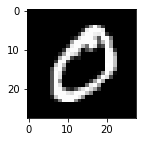

Test Image with Noise


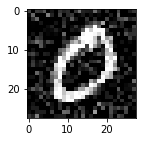

Reconstruction of Noisy Test Images


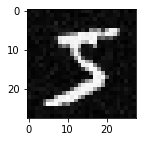

In [59]:
pred = run_MLP_1layer(X_train, X_test, epochs=50, batch_size=1, model_type=1, test_image_number=1)

Results

Since we only trained with 5, it will also predict a 5, regardless of what we use as input. That's why we use several images for input data, so the model can predict a more generic image. 

### Adding another layer

Epoch 1/15
1/1 [==============================] - 0s 211ms/step - loss: 0.2431 - val_loss: 0.1937
Epoch 2/15
1/1 [==============================] - 0s 23ms/step - loss: 0.1875 - val_loss: 0.1540
Epoch 3/15
1/1 [==============================] - 0s 27ms/step - loss: 0.1404 - val_loss: 0.1219
Epoch 4/15
1/1 [==============================] - 0s 23ms/step - loss: 0.1012 - val_loss: 0.0971
Epoch 5/15
1/1 [==============================] - 0s 27ms/step - loss: 0.0698 - val_loss: 0.0793
Epoch 6/15
1/1 [==============================] - 0s 26ms/step - loss: 0.0458 - val_loss: 0.0676
Epoch 7/15
1/1 [==============================] - 0s 24ms/step - loss: 0.0288 - val_loss: 0.0607
Epoch 8/15
1/1 [==============================] - 0s 27ms/step - loss: 0.0175 - val_loss: 0.0571
Epoch 9/15
1/1 [==============================] - 0s 26ms/step - loss: 0.0104 - val_loss: 0.0555
Epoch 10/15
1/1 [==============================] - 0s 25ms/step - loss: 0.0063 - val_loss: 0.0551
Epoch 11/15
1/1 [===========

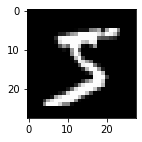

Test Image with Noise


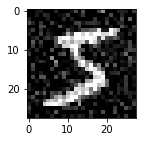

Reconstruction of Noisy Test Images


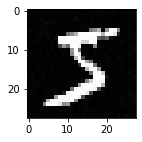

In [72]:
pred = run_MLP_1layer(X_train, X_test, epochs=15, batch_size=1, model_type=2, test_image_number=0)

Results

Adding another layer improves significantly the results, almost equal to the original image.



#### Dog image (high resolution)

In [256]:
x = cv.imread('./Images/300px_dog.jpg',0)
x = x.reshape(1,300,300)


#run_MLP_1layer(x, x, epochs=2, batch_size=1)

Results: there's a limit for the number of neurons per layer, so it's not convenient to use a fully connected layer like the one used on MLP, since the computational cost is very high
